In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from functions.utility import *
from functions.sampling import *

# Metrics

In [2]:
from functions.metrics import *
"""
Test that metric functions behave as expected for perfect similarity:
MSE, MAE, RMSE = 0.
PSNR = infinity.
SSIM = 1.
"""
im = get_im("boss_baby.jpg")

all_metrics(im, im)

MSE: 0.0
RMSE: 0.0
MAE: 0.0
PSNR: inf
SSIM: 1.0




# Test Upsampling

QUESTION - We want to upsample while in the [0,1] floating point range, but do we want to convert back to uint8 [0, 255] format before measuring metrics, or stay in floating point range?

Answer - we will probably want to convert back to uint8 [0, 255] for the visual aspect, but this will obviously result in some error as we are translating the floating point space into a larger space of values. This will give me a chance to put my numerical analysis skills to use.

TypeError: get_tightbbox() missing 1 required positional argument: 'renderer'

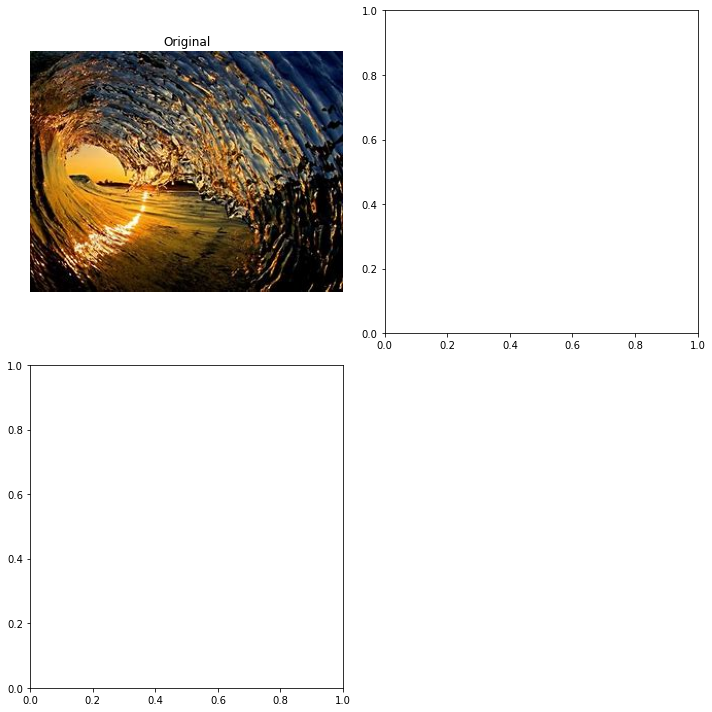

In [6]:
from functions.sampling import *
"""
Test upsampling for prepped approach.
"""
filename = 'wave.jpg'
im = get_im(filename).astype(float) / 255.
im = make_even_shape(im)

smaller_im = cv2_downsample(im)
prepped_im = prep_upsample(smaller_im)

upsampled_im = KNN_upsample_prepped(prepped_im, k=1)

display_prepped_upsampling_results([im, smaller_im, prepped_im, upsampled_im], path='prep_' + filename)

all_metrics(im, upsampled_im)

"""
Test upsampling for no-prep approach.
"""
im = get_im(filename).astype(float) / 255.
im = make_even_shape(im)

smaller_im = cv2_downsample(im)

upsampled_im = KNN_upsample_no_prep(smaller_im, k=1)

display_upsampling_results(smaller_im, upsampled_im, path='up_' + filename)

all_metrics(im, upsampled_im)

Original shape (234, 304, 3)


C:\Users\Nicolas Prate\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nicolas Prate\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Result (upsampled) shape (702, 912, 3)


TypeError: get_tightbbox() missing 1 required positional argument: 'renderer'

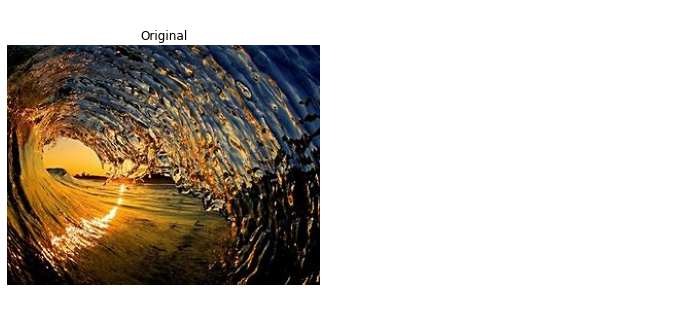

In [4]:
"""
Test upsampling for no-prep approach with variable factor.
"""
im = get_im(filename).astype(float) / 255.
im = make_even_shape(im)
print("Original shape", im.shape)

upsampled_im = KNN_upsample_variable_factor(im, k=1, factor=3)
print("Result (upsampled) shape", upsampled_im.shape)

display_upsampling_results(im, upsampled_im, path='var_' + filename)

# Cannot compute metrics when upsampling to a shape dissimilar from the original image
# Perhaps we can use library functions to reshape/resize the orignal image to our target and then compute metrics

In [ ]:
"""
Test upsampling for no-prep approach with variable and dissimilar factors in both dimensions.
"""
filename = 'boss_baby.jpg' # remove later
im = get_im(filename).astype(float) / 255.
im = make_even_shape(im)
print("Original shape", im.shape)

upsampled_im = KNN_upsample_variable_factors(im, k=2, factor1=2, factor2=4)
print("Result shape", upsampled_im.shape)

display_upsampling_results(im, upsampled_im, path='dyn_h_' + filename)



im = get_im(filename).astype(float) / 255.
im = make_even_shape(im)
print("Original shape", im.shape)

upsampled_im = KNN_upsample_variable_factors(im, k=2, factor1=5, factor2=2)
print("Result shape", upsampled_im.shape)

display_upsampling_results(im, upsampled_im, path='dyn_v_' + filename)


# Cannot compute metrics when upsampling to a shape dissimilar from the original image
# We can compute matrics with respect to the aspect ratio being converted

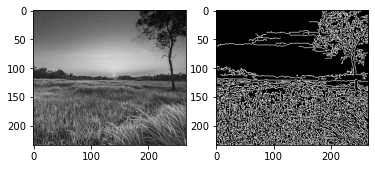

In [5]:
"""
Edge detection to confirm locations needing higher upsampling
"""

def edgeplot(filename: str) -> None:
    im = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(im, 0, 150)
    plt.subplot(121); plt.imshow(im, cmap='gray')
    plt.subplot(122); plt.imshow(edges, cmap='gray')

edgeplot('images/plains.jpg')

**Datasets**:

https://paperswithcode.com/dataset/cifar-100

https://paperswithcode.com/dataset/set14

https://paperswithcode.com/dataset/div2k

Need: Linear Interpolation as baseline

In [47]:
"""
Create a cascade of downsampled test images, upsample each to original size,
then plot metrics.
"""
filename = 'no_black_logo.jpg'
im = get_im(filename).astype(float) / 255.
im = make_even_shape(im)

scale_percents = [50, 25, 20, 10]
factors = [2, 4, 5, 10]
ks = [2, 3, 4, 9]

test_ims = []
for i in range(len(scale_percents)):
    test_ims.append(cv2_downsample(im, scale_percent=scale_percents[i]))

res_ims = []
for i in range(len(test_ims)):
    upsampled_im = KNN_upsample_variable_factor(test_ims[i], k=ks[i], factor=factors[i])
    res_ims.append(upsampled_im)
    
rmses = []
psnrs = []
ssims = []

for i in range(len(res_ims)):
    rmses.append(rmse(im, res_ims[i]))
    psnrs.append(psnr(im, res_ims[i]))
    ssims.append(ssim(im, res_ims[i]))
    
print(rmses)
print(psnrs)
print(ssims)

[0.03755107989412066, 0.05978236618168385, 0.06811707156327304, 0.09687911542379302]
[76.63835498943118, 72.59934160093314, 71.46568423192507, 68.40620031405503]
[0.9999921013194536, 0.9999800526657, 0.9999742134719002, 0.9999489457941454]


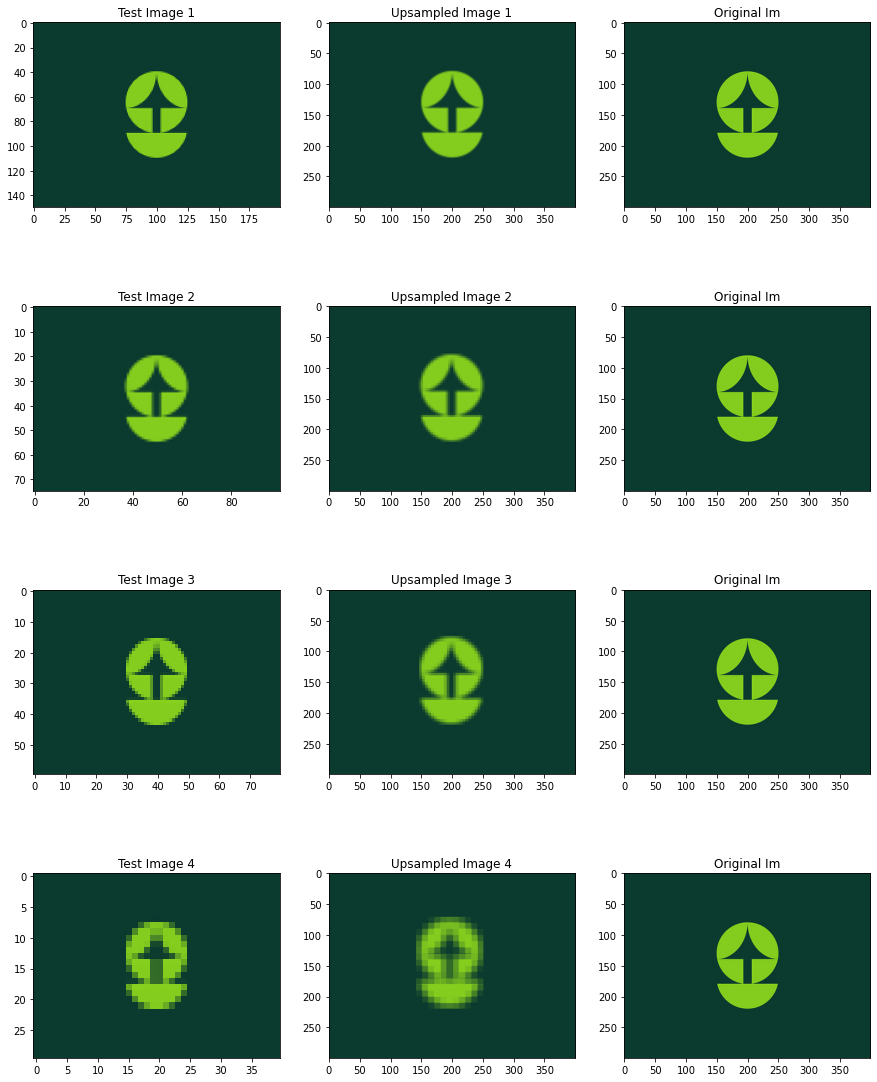

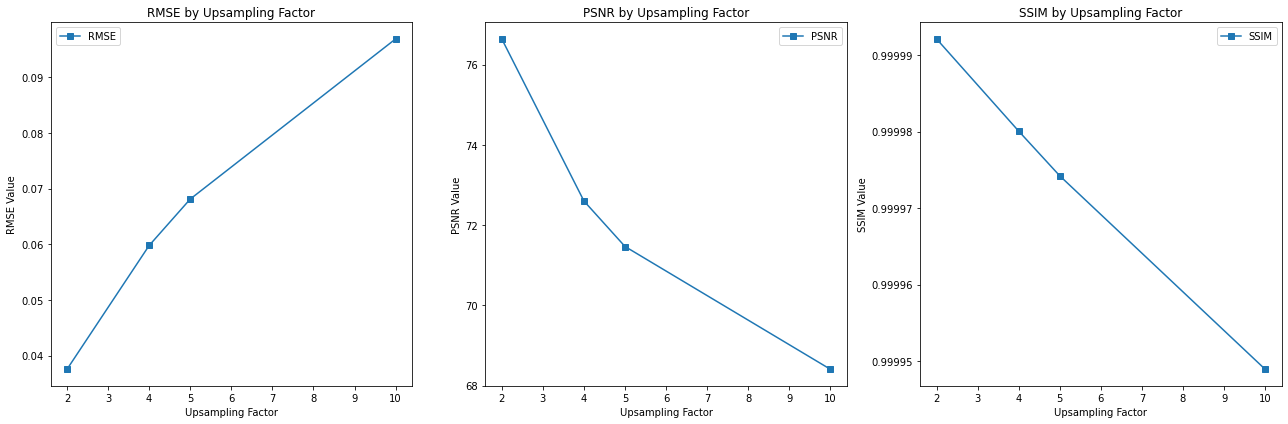

In [49]:
# Display side-by-side image comparisons
# Function to convert an image to uint8 for display
def to_display(im):
    return cv2.convertScaleAbs(im, alpha=(255.0))

# Display side-by-side image comparisons
n = len(test_ims)
fig, axs = plt.subplots(n, 3, figsize=(15, 5 * n))
original_im_display = to_display(im)
for i in range(n):
    test_im_display = to_display(test_ims[i])
    res_im_display = to_display(res_ims[i])

    axs[i, 0].imshow(cv2.cvtColor(test_im_display, cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title(f'Test Image {i+1}')

    axs[i, 1].imshow(cv2.cvtColor(res_im_display, cv2.COLOR_BGR2RGB))
    axs[i, 1].set_title(f'Upsampled Image {i+1}')
    
    axs[i, 2].imshow(cv2.cvtColor(original_im_display, cv2.COLOR_BGR2RGB))
    axs[i, 2].set_title('Original Im')
    
plt.show()

# Create a figure with 3 subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# RMSE Plot
axs[0].plot(factors, rmses, 's-', label='RMSE')
axs[0].set_xlabel('Upsampling Factor')
axs[0].set_ylabel('RMSE Value')
axs[0].set_title('RMSE by Upsampling Factor')
axs[0].legend()

# PSNR Plot
axs[1].plot(factors, psnrs, 's-', label='PSNR')
axs[1].set_xlabel('Upsampling Factor')
axs[1].set_ylabel('PSNR Value')
axs[1].set_title('PSNR by Upsampling Factor')
axs[1].legend()

# SSIM Plot
axs[2].plot(factors, ssims, 's-', label='SSIM')
axs[2].set_xlabel('Upsampling Factor')
axs[2].set_ylabel('SSIM Value')
axs[2].get_yaxis().get_major_formatter().set_useOffset(False)
axs[2].set_title('SSIM by Upsampling Factor')
axs[2].legend()

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


# Applying Upscaling on Cifar-10 Dataset

### Extract dataset from tar file.

In [51]:
import tarfile

# Replace this with the path to your 'cifar-10-python.tar.gz' file
tar_file_path = 'cifar-10-python.tar.gz'

# Open the tar file
with tarfile.open(tar_file_path, "r:gz") as tar:
    # Extract all the contents into the current directory
    tar.extractall()

print("Extraction complete.")


Extraction complete.


### Load dataset

In [66]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
batch_file = 'cifar-10-batches-py/data_batch_1'
batch = load_cifar10_batch(batch_file)

# The data key contains a 10000x3072 numpy array of uint8s. 
# Each row of the array stores a 32x32 color image. 
# The first 1024 entries contain the red channel values, 
# the next 1024 the green, and the final 1024 the blue.
images = batch[b'data']
images = images.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")

### Use N images to upsample at varying factors

In [82]:
from tqdm import tqdm

N = 10
f2_res = []
f4_res = []
f8_res = []

f4_2_res = []
f8_2_res = []
for i in tqdm(range(N)):
    float_im = images[i].astype(float) / 255
    f2_res.append(KNN_upsample_variable_factor(float_im, k=1, factor=2))
    f4_res.append(KNN_upsample_variable_factor(float_im, k=3, factor=4))
    f8_res.append(KNN_upsample_variable_factor(float_im, k=7, factor=8))
    
    f4_2_res.append(KNN_upsample_variable_factor(f2_res[-1], k=1, factor=2))
    f8_2_res.append(KNN_upsample_variable_factor(f4_2_res[-1], k=1, factor=2))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.04s/it]


### Visualize results

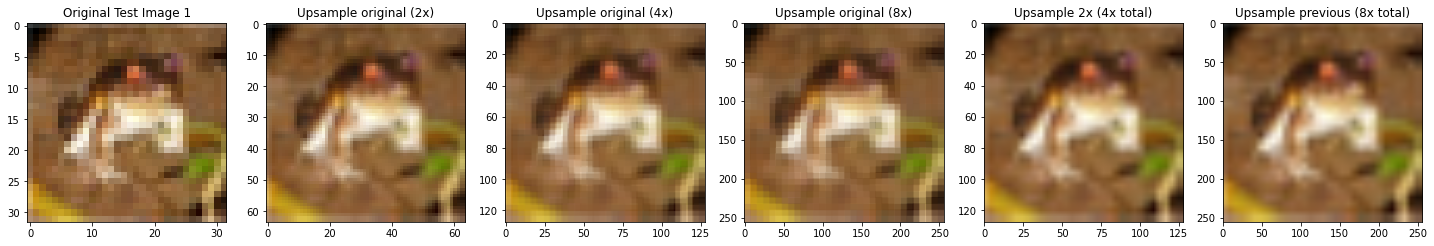

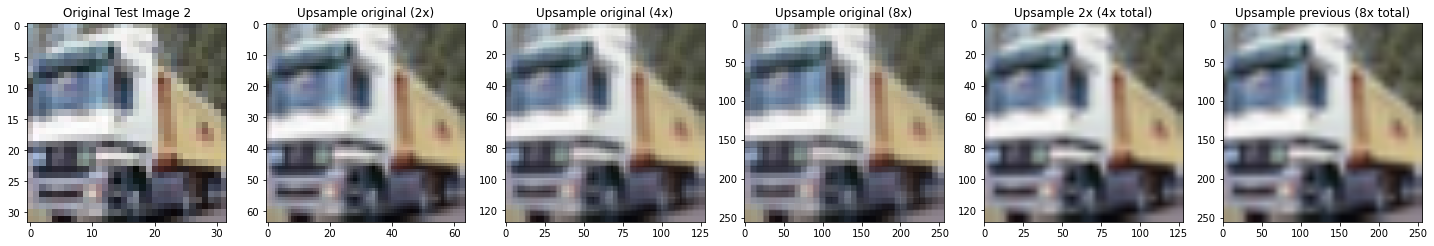

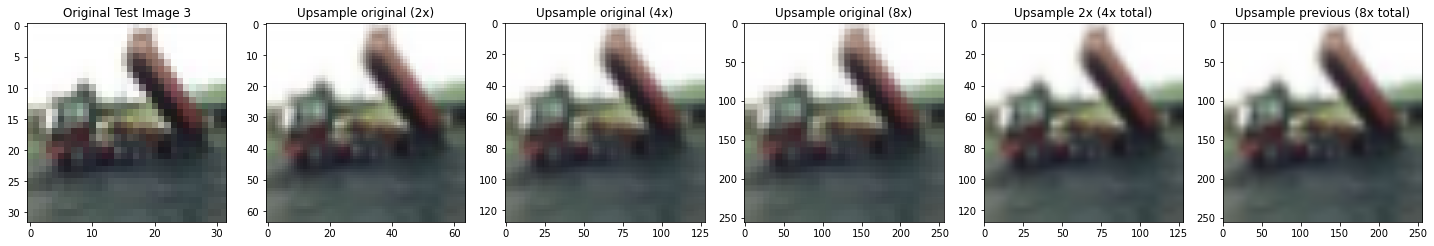

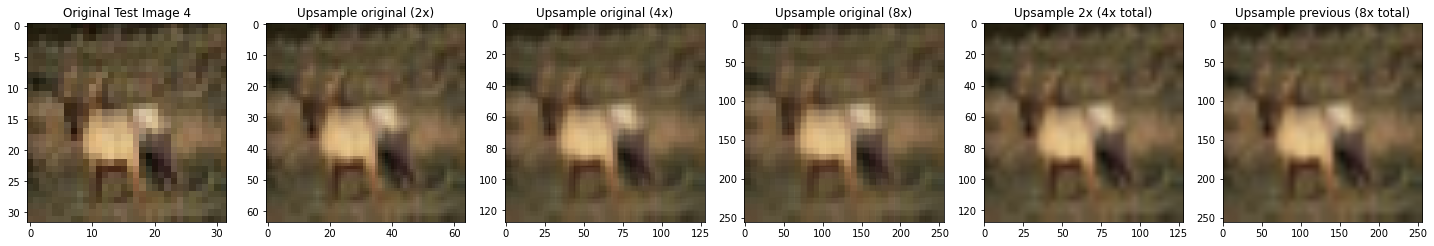

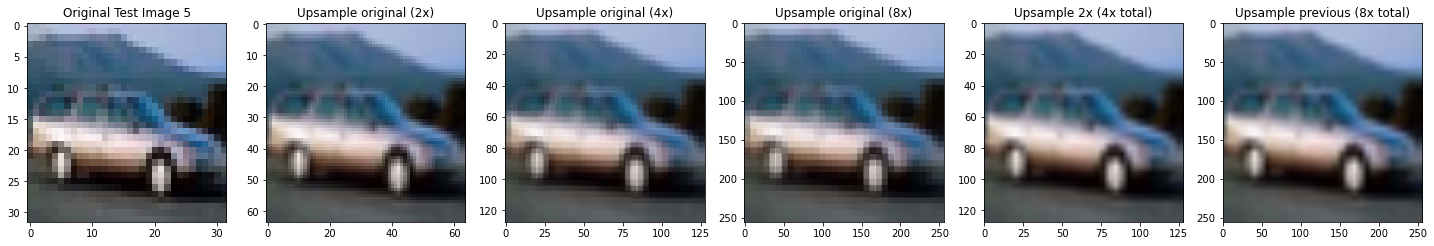

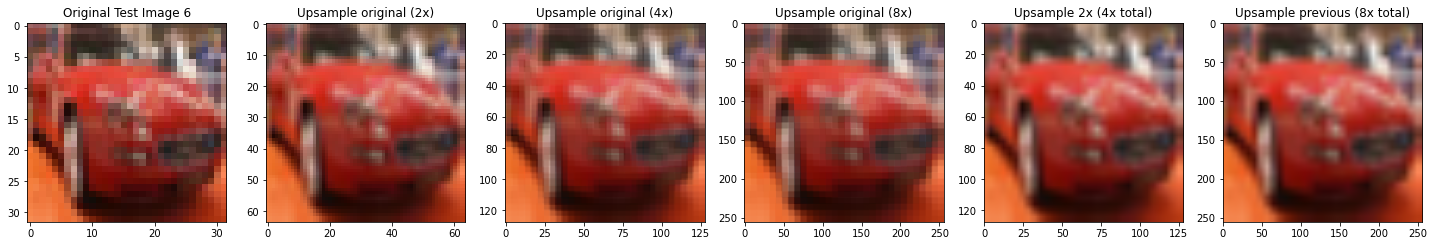

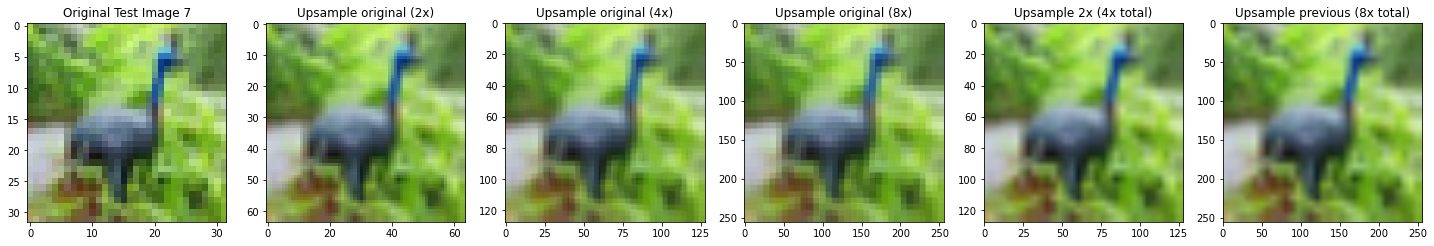

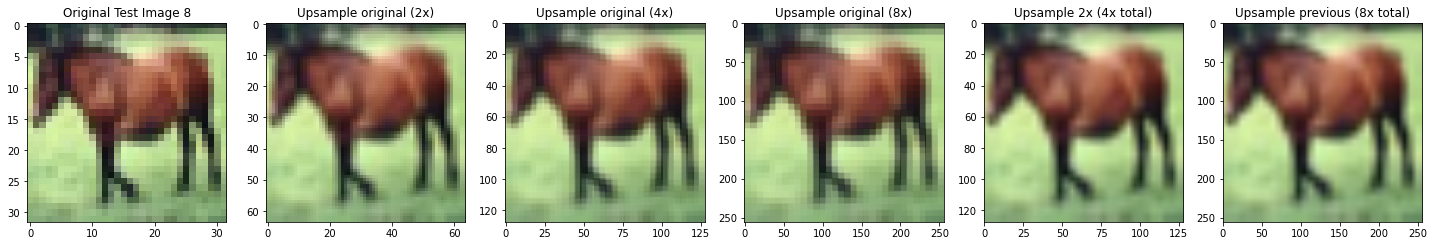

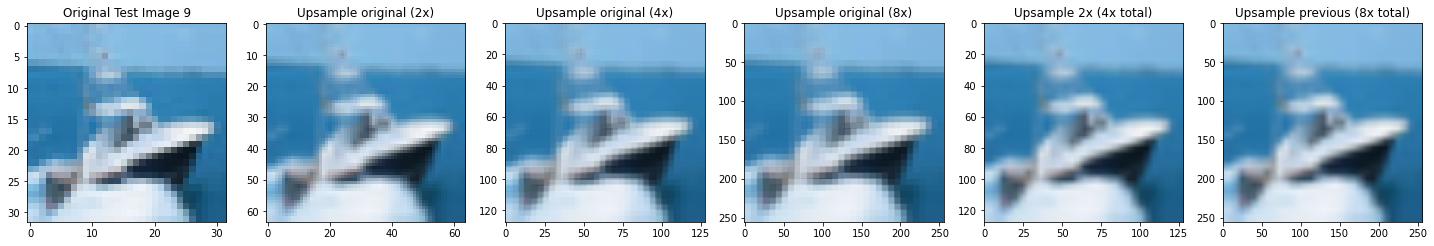

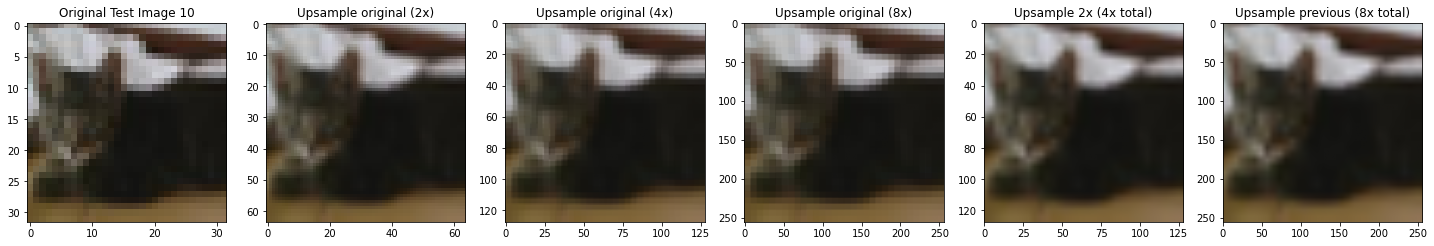

In [89]:
# Display side-by-side image comparisons
n = len(upsampled_ims)
for i in range(N):
    fig, axs = plt.subplots(1, 6, figsize=(25, 5))

    axs[0].imshow(images[i])
    axs[0].set_title(f'Original Test Image {i+1}')

    axs[1].imshow(f2_res[i])
    axs[1].set_title('Upsample original (2x)')
    
    axs[2].imshow(f4_res[i])
    axs[2].set_title('Upsample original (4x)')
    
    axs[3].imshow(f8_res[i])
    axs[3].set_title('Upsample original (8x)')
    
    axs[4].imshow(f4_2_res[i])
    axs[4].set_title('Upsample 2x (4x total)')
    
    axs[5].imshow(f8_2_res[i])
    axs[5].set_title('Upsample previous (8x total)')

    plt.show()